## 01. Exploring parameters in DM halos and sub-halos

The notebook is divided into the following sections:
1. Loading data and defining input parameters
2. Studying sizes of haloes and sub-haloes

**Script written by**: Soumya Shreeram <br>
**Project supervised by**: Johan Comparat <br>
**Date**: 23rd February 2021

Import required packages

In [1]:
# astropy modules
import astropy.units as u
import astropy.io.fits as fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM, z_at_value

import numpy as np

# scipy modules
from scipy.spatial import KDTree
from scipy.interpolate import interp1d

# system imports
import os
import sys
import importlib as ib

# plotting imports
import matplotlib
from mpl_toolkits import axes_grid1
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
from matplotlib.legend_handler import HandlerLine2D

Load the imported file(s) that contains all the functions used in this notebooks

In [2]:
%matplotlib inline
font = {'family' : 'serif',
        'weight' : 'medium',
        'size'   : 20}
matplotlib.rc('font', **font)

In [3]:
sys.path.append('imported_files/')
import Exploring_DM_Haloes as edh
import plotting as pt

There exists 734 pixels in the simulation, each covering 53 deg$^2$ in the sky. However, there are few pixels for which there exists only a galaxy file, but no AGN file (for example: 700-734). We start off by exploring arbitary particular pixel that covers all the way from redshift $z = 0-5.6$.

### 1. Defining input parameters

In [4]:
# look back into redshifts until...
redshift_limit = 1.5

# agn parameters
agn_FX_soft = 4e-14

# galaxy parameters
galaxy_SMHMR_mass = 9 # unit?

# halo parameters
halo_mass_500c = 10**13.7 # solar masses

cluster_params = [halo_mass_500c]

# array deciding the cuts in the merger times and their linestyles
t_merger_cut_arr, l = [1, 2.5, 5], ['-', '--', ':']

Define cosmology used in the notebook

In [5]:
cosmo = FlatLambdaCDM(H0=67.77*u.km/u.s/u.Mpc, Om0=0.307115)
h = 0.6777
L_box = 1000.0 / h

### 2. Open files and get relevant data

In [6]:
# halo directory number
pixel_no = '000000'

agn_filename = edh.getFilename('agn', pixel_no = pixel_no)
galaxy_filename = edh.getFilename('galaxy', pixel_no = pixel_no)

# halo files are divided into multiple groups
# TODO: create new object that saves them together
halo_filename0 = edh.getFilename('halo', pixel_no = [pixel_no, 0])
halo_filename1 = edh.getFilename('halo', pixel_no = [pixel_no, 1])
halo_filename2 = edh.getFilename('halo', pixel_no = [pixel_no, 2])

# read the input agn and galaxy files
hd_agn = Table.read(agn_filename, format='fits') 
hd_galaxy = Table.read(galaxy_filename, format='fits')

# read the input halo files
hd_halo0 = Table.read(halo_filename0, format='fits')
hd_halo1 = Table.read(halo_filename1, format='fits')
hd_halo2 = Table.read(halo_filename2, format='fits')

Extracting positions and redshifts of the AGNs, galaxies, and halos

In [8]:
ib.reload(edh)
# central and sub-halos
pos_z_cen, pos_z_sat = edh.getClusterPositionsRedshift(hd_halo0, hd_halo1, hd_halo2, cluster_params, redshift_limit)

# agns
pos_z_AGN, scale_merger_AGN,  conditions_agn = edh.getAgnData(hd_agn, agn_FX_soft, redshift_limit)    

# galaxies i.e. non-active galaxies
pos_z_gal, scale_merger_gal, conditions_gal = edh.getGalaxyData(hd_galaxy, galaxy_SMHMR_mass, redshift_limit)

In [9]:
print('AGNs/haloes in the pixel are in z = %.2f to %.2f'%(np.min(pos_z_AGN[2]), np.max(pos_z_AGN[2])))
num_total_halos = len(pos_z_cen[2]) + len(pos_z_sat[2])
print('%d clusters, %d AGNs, %d galaxies'%(num_total_halos, len(pos_z_AGN[2]), len(pos_z_gal[0])))

AGNs/haloes in the pixel are in z = 0.03 to 1.50
2189 clusters, 507 AGNs, 2915975 galaxies


### 3. Study distribution of AGNs in haloes

Plotting the chosen pixel with the galaxies, AGNs and clusters therein. Note that this plot comprises of objects in the defined reshift range.

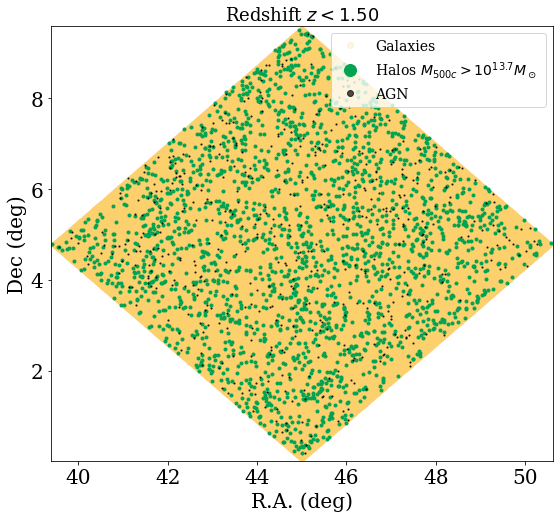

In [48]:
pt.plotAgnClusterDistribution(pos_z_cen, pos_z_AGN, pos_z_gal, halo_mass_500c)

Plotting the AGN/galaxy ratio as a function of the chosen redshift bins.

z<1.50


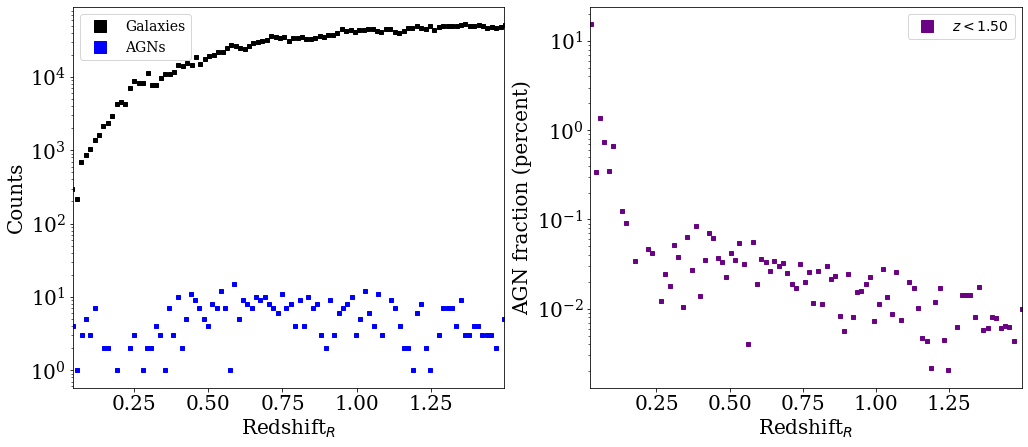

In [94]:
redshift_bins = pt.plotAGNfraction(pos_z_cen, pos_z_AGN, pos_z_gal, redshift_limit, bin_size=100) 

AGNs: 507, Host (central) halos: 2159, Sattelite halos: 30


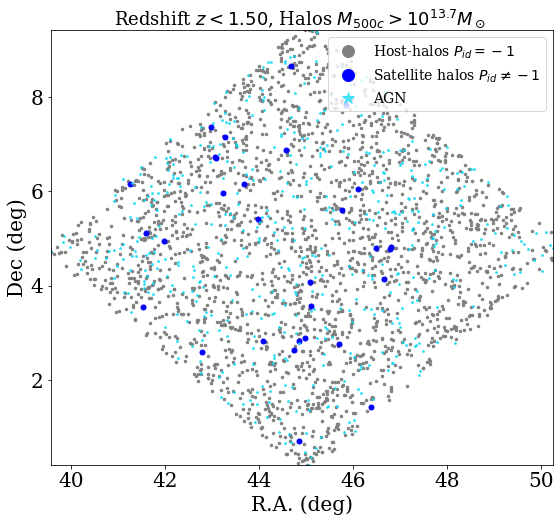

In [47]:
pt.plotHostSubHalos(pos_z_cen, pos_z_sat, pos_z_AGN, redshift_limit, cluster_params)

### 4. Studying merger effects in galaxies and AGNs

Plotting the merger history of the chosen sample of AGNs and galaxies below the chosen redshift limit.

Objects with merger redshifts z < 15.67


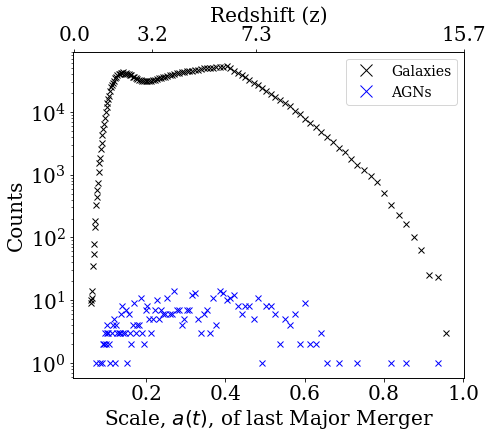

In [93]:
scale_merger_gal_sample, counts_gal_sample = np.unique(scale_merger_gal, return_counts = True)
scale_merger_agn_sample, counts_agn_sample = np.unique(scale_merger_AGN, return_counts = True)

pt.plotMergerDistribution(scale_merger_gal_sample, counts_gal_sample, scale_merger_agn_sample, counts_agn_sample, cosmo, redshift_limit)

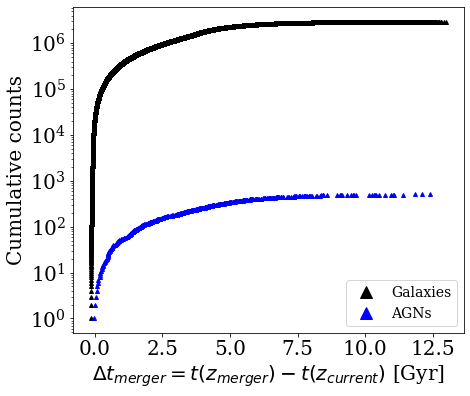

In [92]:
ax = pt.plotTimeSinceMergerDist(scale_merger_AGN, scale_merger_gal, pos_z_AGN[2], pos_z_gal[2], cosmo, [False, 200], redshift_limit=redshift_limit)

Since we are interested in handles to access central and satellite information in AGNs and galaxies, the following code block extracts the `hd_agn(gal)` handles for the chosen criteria.

In [22]:
cen_sat_AGN = edh.cenSatObjects(conditions_agn, hd_agn, cluster_params[0])
cen_sat_gal = edh.cenSatObjects(conditions_gal, hd_galaxy, cluster_params[0])

By dividing the AGN and galaxy sample into central and satellite samples, it is possible to see the merger impacts in each of the samples separately.

Objects below z:  1.5


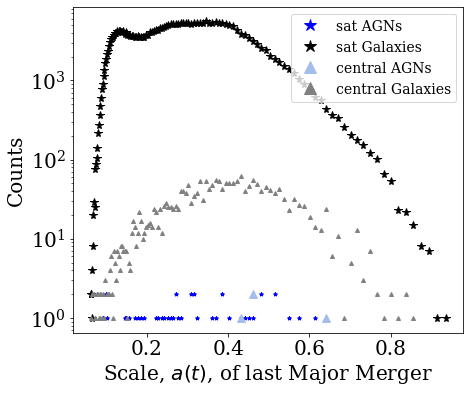

In [103]:
plot_params = pt.plotCentralSatelliteScaleMergers(cen_sat_AGN, cen_sat_gal, redshift_limit) 

Ploting the cumulative counts as a function of the time since merger for **central galaxies and AGNs**

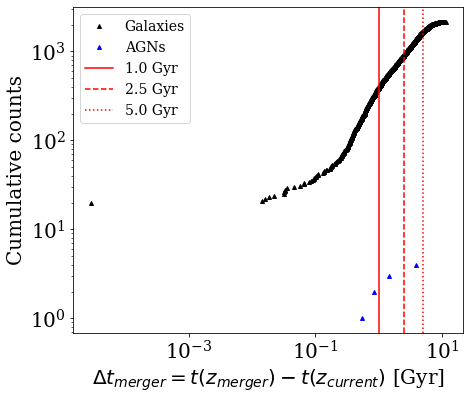

In [101]:
ax, dt_m_cagn, dt_m_cgal = pt.plotTimeSinceMergerDist(cen_sat_AGN[0]['HALO_scale_of_last_MM'], cen_sat_gal[0]['HALO_scale_of_last_MM'], cen_sat_AGN[0]['redshift_R'], cen_sat_gal[0]['redshift_R'], cosmo, [False, 500], redshift_limit)

# plot the cuts in the merger times
pt.plotMergerTimeCuts(ax, t_merger_cut_arr, l) 
plt.savefig('figures/t_m_dist_central_z_%.2f_with_cuts.pdf'%redshift_limit, facecolor='w', edgecolor='w')

Ploting the cumulative counts as a function of the time since merger for **satellite galaxies and AGNs**

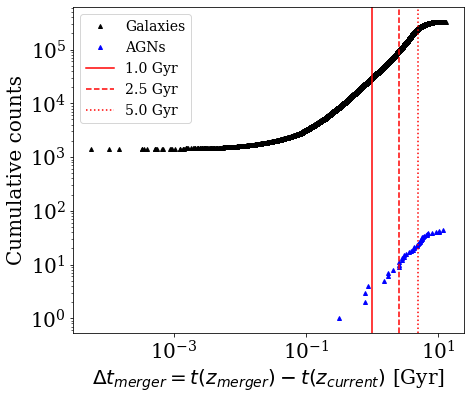

In [102]:
ax, dt_m_sagn, dt_m_sgal = pt.plotTimeSinceMergerDist(cen_sat_AGN[1]['HALO_scale_of_last_MM'], cen_sat_gal[1]['HALO_scale_of_last_MM'], cen_sat_AGN[1]['redshift_R'], cen_sat_gal[1]['redshift_R'], cosmo, [False, 500], redshift_limit)

# plot the cuts in the merger times
pt.plotMergerTimeCuts(ax, t_merger_cut_arr, l)
plt.savefig('figures/t_m_dist_sat_z_%.2f_with_cuts.pdf'%redshift_limit, facecolor='w', edgecolor='w')

Grouping together the $\Delta t_{merger}$ for the satellite and central AGNs and galaxies.

In [ ]:
dt_m = [dt_m_cagn, dt_m_sagn, dt_m_cgal, dt_m_sgal]

Ploting the corelation between redshift and $\Delta t_{merger}$

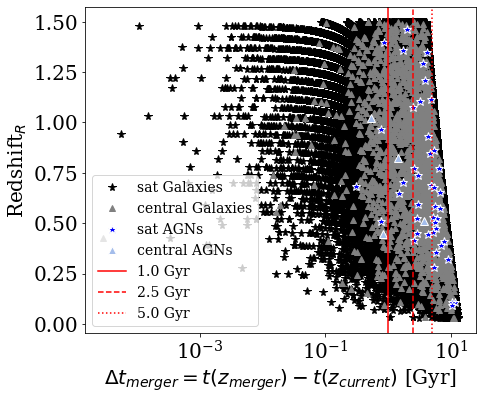

In [118]:
ax = pt.mergerRedshiftPlot(cen_sat_AGN, cen_sat_gal, dt_m, plot_params, redshift_limit)

# plot the cuts in the merger times
pt.plotMergerTimeCuts(ax, t_merger_cut_arr, l)